In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from PIL import Image
import concurrent.futures
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Enable GPU usage

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU is available and will be used for training.")
else:
    print("GPU is not available. Using CPU.")

GPU is available and will be used for training.


# Paths to your Train and Test folders (update these paths)

In [3]:
TRAIN_DIR = "/kaggle/input/gtsrb-german-traffic-sign"
TEST_DIR = "/kaggle/input/gtsrb-german-traffic-sign"
META_CSV = "/kaggle/input/gtsrb-german-traffic-sign/Meta.csv"
TRAIN_CSV = "/kaggle/input/gtsrb-german-traffic-sign/Train.csv"
TEST_CSV = "/kaggle/input/gtsrb-german-traffic-sign/Test.csv"

# Load CSV data

In [4]:
meta_df = pd.read_csv(META_CSV)
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

# Create a dictionary to map SignId to Sign names from Meta.csv

In [5]:
sign_id_to_name = {
    0: "Speed limit (20km/h)",
    1: "Speed limit (30km/h)",
    2: "Speed limit (50km/h)",
    3: "Speed limit (60km/h)",
    4: "Speed limit (70km/h)",
    5: "Speed limit (80km/h)",
    6: "End of speed limit (80km/h)",
    7: "Speed limit (100km/h)",
    8: "Speed limit (120km/h)",
    9: "No passing",
    10: "No passing for vehicles over 3.5 metric tons",
    11: "Right-of-way at the next intersection",
    12: "Priority road",
    13: "Yield",
    14: "Stop",
    15: "No vehicles",
    16: "Vehicles over 3.5 metric tons prohibited",
    17: "No entry",
    18: "General caution",
    19: "Dangerous curve to the left",
    20: "Dangerous curve to the right",
    21: "Double curve",
    22: "Bumpy road",
    23: "Slippery road",
    24: "Road narrows on the right",
    25: "Road work",
    26: "Traffic signals",
    27: "Pedestrians",
    28: "Children crossing",
    29: "Bicycles crossing",
    30: "Beware of ice/snow",
    31: "Wild animals crossing",
    32: "End of all speed and passing limits",
    33: "Turn right ahead",
    34: "Turn left ahead",
    35: "Ahead only",
    36: "Go straight or right",
    37: "Go straight or left",
    38: "Keep right",
    39: "Keep left",
    40: "Roundabout mandatory",
    41: "End of no passing",
    42: "End of no passing by vehicles over 3.5 metric tons"
}

In [6]:
TARGET_SIZE = (75, 75)  # Define a consistent size for all images

# Loading and resizing image

In [7]:
def load_image(image_path, roi_coords=None):
    image = Image.open(image_path).convert('RGB')  # Ensure 3 channels (RGB)
    if roi_coords:
        image = image.crop(roi_coords)  # Crop based on the provided coordinates
    image = image.resize(TARGET_SIZE)  # Resize to target size
    return np.array(image, dtype=np.float32)

# Loading training data with ThreadPoolExecutor for parallelism

In [8]:
def load_train_data(train_csv, data_dir):
    images = []
    labels = []
    with concurrent.futures.ThreadPoolExecutor() as executor:
        future_to_image = {}
        for _, row in train_csv.iterrows():
            image_path = os.path.join(data_dir, row['Path'])
            roi_coords = (row['Roi.X1'], row['Roi.Y1'], row['Roi.X2'], row['Roi.Y2'])
            future = executor.submit(load_image, image_path, roi_coords)
            future_to_image[future] = row['ClassId']

        for future in concurrent.futures.as_completed(future_to_image):
            image = future.result()
            label = future_to_image[future]
            images.append(image)
            labels.append(label)

    images = np.stack(images, axis=0)  # Stack images into a uniform array
    labels = np.array(labels)
    return images, labels

# Loading test data with ThreadPoolExecutor for parallelism

In [9]:
def load_test_data(test_csv, data_dir):
    images = []
    labels = []
    with concurrent.futures.ThreadPoolExecutor() as executor:
        future_to_image = {}
        for _, row in test_csv.iterrows():
            image_path = os.path.join(data_dir, row['Path'])
            roi_coords = (row['Roi.X1'], row['Roi.Y1'], row['Roi.X2'], row['Roi.Y2'])
            future = executor.submit(load_image, image_path, roi_coords)
            future_to_image[future] = row['ClassId']
        
        for future in concurrent.futures.as_completed(future_to_image):
            image = future.result()
            label = future_to_image[future]
            images.append(image)
            labels.append(label)
    
    images = np.stack(images, axis=0)  # Stack images into a uniform array
    labels = np.array(labels)
    return images, labels

# Load the training and testing data

In [10]:
train_images, train_labels = load_train_data(train_df, TRAIN_DIR)
test_images, test_labels = load_test_data(test_df, TEST_DIR)

# Normalize image data

In [11]:
train_images = train_images / 255.0
test_images = test_images / 255.0

# Convert labels to one-hot encoding

In [12]:
train_labels = to_categorical(train_labels, num_classes=43)
test_labels = to_categorical(test_labels, num_classes=43)

# Train/validation split

In [13]:
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# Use a pre-trained model (MobileNetV2) for feature extraction

In [14]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3))
base_model.trainable = True  # Unfreeze some layers for fine-tuning

/tmp/ipykernel_23/3952067719.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Create the model

In [15]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.4),
    Dense(512, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dense(43, activation='softmax')
])

# Compile the model

In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Add callbacks for early stopping and learning rate reduction

In [17]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train the model using data augmentation

In [18]:
steps_per_epoch = max(1, len(train_images) // 64)

if len(train_images) > 0:
    model.fit(
        tf.data.Dataset.from_tensor_slices((train_images, train_labels))
        .map(lambda x, y: (tf.image.random_brightness(x, max_delta=0.2), y))
        .map(lambda x, y: (tf.image.random_contrast(x, 0.8, 1.2), y))
        .shuffle(buffer_size=1024)
        .batch(64),
        epochs=20,
        validation_data=(val_images, val_labels),
        steps_per_epoch=steps_per_epoch,
        callbacks=[early_stopping, reduce_lr]
    )

Epoch 1/20


I0000 00:00:1730865200.442001      80 service.cc:145] XLA service 0x7b5fc0002f80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730865200.442071      80 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  3/490 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.0347 - loss: 4.6047   

I0000 00:00:1730865223.042150      80 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_multiply_reduce_subtract_fusion_8', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1730865223.086138      80 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


490/490 ━━━━━━━━━━━━━━━━━━━━ 75s 51ms/step - accuracy: 0.2589 - loss: 3.0693 - val_accuracy: 0.4609 - val_loss: 2.1114 - learning_rate: 1.0000e-04
Epoch 2/20
  1/490 ━━━━━━━━━━━━━━━━━━━━ 2:37:41 19s/step - accuracy: 0.2857 - loss: 2.1029

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


490/490 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.2857 - loss: 2.1029 - val_accuracy: 0.4620 - val_loss: 2.1126 - learning_rate: 1.0000e-04
Epoch 3/20
490/490 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.7967 - loss: 0.7297 - val_accuracy: 0.7127 - val_loss: 1.0269 - learning_rate: 1.0000e-04
Epoch 4/20
490/490 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5714 - loss: 1.4751 - val_accuracy: 0.7123 - val_loss: 1.0277 - learning_rate: 1.0000e-04
Epoch 5/20
490/490 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.9334 - loss: 0.2497 - val_accuracy: 0.8410 - val_loss: 0.5946 - learning_rate: 1.0000e-04
Epoch 6/20
490/490 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8571 - loss: 0.9353 - val_accuracy: 0.8417 - val_loss: 0.5957 - learning_rate: 1.0000e-04
Epoch 7/20
490/490 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.9716 - loss: 0.1157 - val_accuracy: 0.9319 - val_loss: 0.2546 - learning_rate: 1.0000e-04
Epoch 8/20
490/490 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.00

# Evaluate the model on the validation set

In [19]:
val_loss, val_accuracy = model.evaluate(val_images, val_labels)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9950 - loss: 0.0180
Validation Accuracy: 99.38%


# Predictions for evaluation metrics

In [20]:
y_pred = model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(test_labels, axis=1)

395/395 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step


# Calculate evaluation metrics

In [21]:
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

# Print evaluation metrics

In [22]:
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

Confusion Matrix:
[[ 59   0   0 ...   0   0   0]
 [  0 714   0 ...   0   0   0]
 [  0   3 737 ...   0   0   0]
 ...
 [  0   0   0 ...  79   0   0]
 [  0   0   0 ...   0  54   0]
 [  0   0   0 ...   0   6  75]]
Accuracy: 97.08%
Precision: 0.97
Recall: 0.97
F1 Score: 0.97


# Show a few example predictions

In [23]:
def show_predictions(images, labels, model, num=5):
    if len(images) > 0:
        indices = np.random.choice(len(images), num, replace=False)
        for i in indices:
            image = images[i]
            true_label = np.argmax(labels[i])
            prediction = np.argmax(model.predict(image.reshape(1, TARGET_SIZE[0], TARGET_SIZE[1], 3)))
            true_sign_name = sign_id_to_name.get(true_label, "Unknown")
            predicted_sign_name = sign_id_to_name.get(prediction, "Unknown")
            plt.imshow((image * 255).astype(np.uint8))  # Convert back to 0-255 range for display
            plt.title(f'True: {true_sign_name}, Predicted: {predicted_sign_name}')
            plt.axis('off')
            plt.show()

# Show some predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


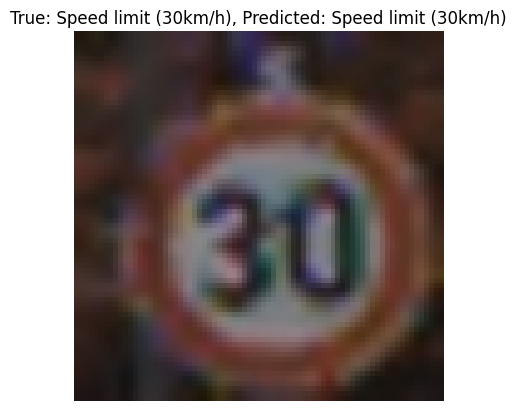

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


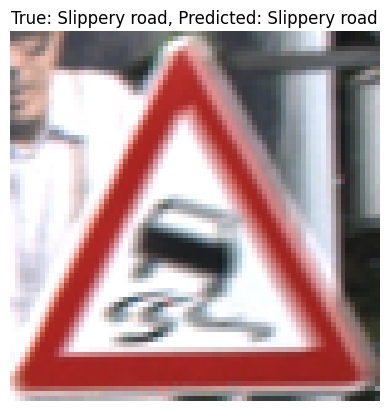

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


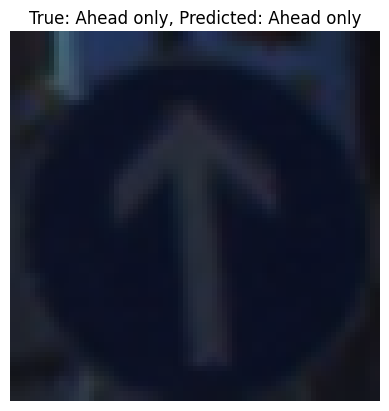

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


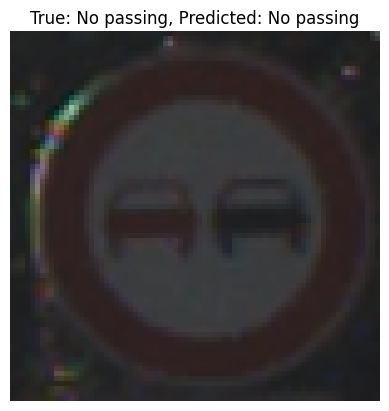

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


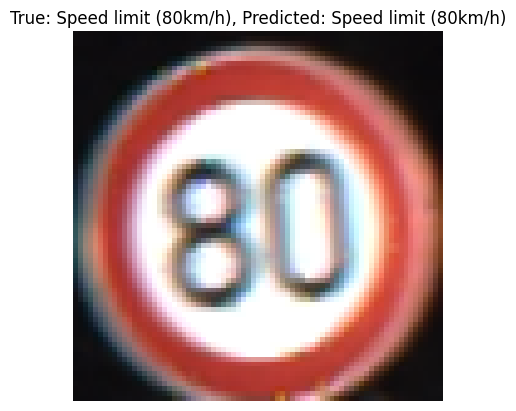

In [24]:
show_predictions(test_images, test_labels, model)